# Machine Learning LAB 6: CLASSIFICATION - Characters Classification with Neural Networks

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks about **CLASSIFICATION**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Characters Classification with Neural Networks

In this notebook we are going to use the **Neural Networks** for image classification. We are going to use a dataset of traditional japanese handwritten kana: [*Kuzushiji-MNIST*](https://github.com/rois-codh/kmnist) (or *K-MNIST* for short).

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

---

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_mnist` -> function to load the K-MNIST dataset,
2. `plot_input` -> function to plot the input image,
3. `param_count`-> function to compute the number of learnable parameters of a MLP given the size of its hidden layers,
4. `plot_accuracies` -> function to plot the accuracies of the MLP,
5. `plot_losses` -> function to plot the losses of the MLP,
6. `plot_conf_matrix` -> function to plot the confusion matrix of the MLP.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def load_mnist(path: str, kind: str = 'train') -> tp.Tuple[np.ndarray, np.ndarray]:
    # Define the path to the data
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    
    # Load the data into numpy arrays (from the gzip files)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    
    return images, labels

In [3]:
#function for plotting a image and printing the corresponding label
def plot_input(data: np.ndarray, labels: np.array, index) -> None:
    if type(index) == int:
        index = [index]
    
    _, ax = plt.subplots(1, len(index))

    if type(ax) != np.ndarray:
        ax = [ax]

    for i, ax in enumerate(ax):
        ax.imshow(
            data[i].reshape(28, 28),
            cmap=plt.cm.gray_r,
            interpolation="nearest"
        )
        ax.set_title("Label: %i" % labels[i], fontsize = 10)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def param_count(hl_size: int, x: np.ndarray, y: np.ndarray) -> int:
    tot = 0
    input_size, output_size = x.shape[1], len(y)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

In [5]:
def plot_accuracies(accuracies: tp.List[float], hl_labels: tp.List[str], titles: tp.List[str] = None) -> None:
    _, ax = plt.subplots(1, len(accuracies), figsize=(6 * len(accuracies), 5))

    if type(ax) != np.ndarray:
        ax = [ax]
    
    for i, ax in enumerate(ax):
        ax.plot(accuracies[i])
        ax.set_xlabel("Number of learnable params")
        ax.set_title("Accuracy")
        ax.set_xticks(np.arange(0,len(hl_labels[i])))
        ax.set_xticklabels(hl_labels[i])
        if titles is not None:
            ax.set_title(titles[i])
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_loss(losses: tp.Dict[float, np.ndarray]) -> None:
    legend = True

    # Plot all the losses
    for key, value in losses.items():
        if key == None:
            plt.plot(value)
            legend = False
        else:
            plt.plot(value, label=f"lr: {key}")

    # Plot the legend, title and labels
    plt.title("Losses")
    if legend:
        plt.legend(loc = 1)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) Classification with Neural Networks (using Scikit-Learn)

In the first part of this notebook we are going to implement a simple *MLP* using the *Scikit-Learn* library.

Now load the dataset using the `load_mnist` function and and rescale the data in the range [0,1].

In [8]:
# Load the data
x, y = load_mnist("data")

# Print the number of samples in the dataset
print("Number of samples in the MNIST dataset:", x.shape[0])

# Print the minimum and maximum values of the input
print("Minimum and maximum values of the input:", np.min(x), np.max(x))

# Rescale the data in [0,1]
x = x / np.max(x)

# Print the minimum and maximum values of the input after rescaling
print("Minimum and maximum values of the input after rescaling:", np.min(x), np.max(x))

Number of samples in the MNIST dataset: 60000
Minimum and maximum values of the input: 0 255
Minimum and maximum values of the input after rescaling: 0.0 1.0


Now split into training and test. We start with a small training set of $600$ samples to reduce computation time while $4000$ samples will be used for testing. Make sure that each label is present at least $10$ times in training frequencies.

In [9]:
# Random permute the data (both train and test set) and split into training and
# test taking the first 600 data samples as training and the rests as test

# Create a list of indices
idx = np.arange(x.shape[0])
# Randomly shuffle the indices
np.random.shuffle(idx)
# Shuffle the dataset
x = x[idx]
y = y[idx]
n=x.shape[0]

# We split the dataset in train and test
m_training=600

# m_test is the number of samples in the test set (total-training)
m_test =  x.shape[0] - m_training
X_training =  x[:m_training]
Y_training =  y[:m_training]
X_test =   x[m_training:]
Y_test =  y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\n")

# Print the number of unique labels (with the correspondent 
# frequency) in the training set and in the test set

labels_train, freqs_train = np.unique(Y_training, return_counts=True)
print("Labels in training dataset: ", labels_train)
print("Frequencies in training dataset: ", freqs_train)
print("\n")
labels_test, freqs_test = np.unique(Y_test, return_counts=True)
print("Labels in test dataset: ", labels_test)
print("Frequencies in test dataset: ", freqs_test)

Number of samples in the train set: 600
Number of samples in the test set: 59400


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [61 61 55 52 60 64 61 55 65 66]


Labels in test dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test dataset:  [5939 5939 5945 5948 5940 5936 5939 5945 5935 5934]


Plot three samples from the dataset, together with their label (use the function))

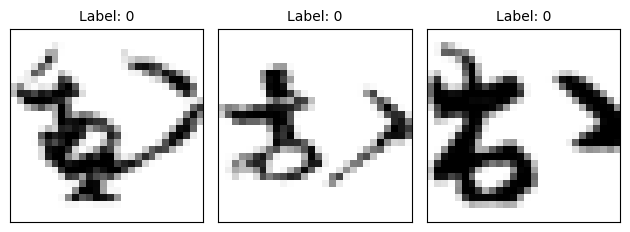

In [10]:
ind=np.random.rand(3)
plot_input(x,y,ind)

### 

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter = $200$, alpha = $1 \cdot 10^{-4}$, solver = 'sgd', tol = $1 \cdot 10^{-4}$, learning_rate_init = $0.1$, random_state = ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to $3$ layers and, for each layer, its maximum size can be of $50$. Evaluate the architectures you chose using GridSearchCV with cv = $5$.

You can reduce the number of iterations if the running time is too long on your computer.

In [11]:
# These are sample values but feel free to change them as you like,
# try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10)]}

# Create a MLP classifier using scikit-learn
MLP=MLPClassifier(activation = 'relu', max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4,
                  learning_rate_init = 0.1)

# Perform a grid search varying over the given parameters for cross validation (k-fold)
models=GridSearchCV(MLP,parameters,cv=5)
models.fit(X_training,Y_training)

# Print the best estimator parameters
print("the best model is:\n")
print(models.best_estimator_)
print("\n")
print("with score {:.2f}".format(models.best_score_))
print("and best parameters {}".format(models.best_params_))

the best model is:

MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.1, solver='sgd')


with score 0.74
and best parameters {'hidden_layer_sizes': (20,)}


### Evaluate the best model

Plot the train and test accuracies as a function of the numbero of neurons in your neural network. Print also the computation time for the various configuration you try.

While performing the *MLP* train with different hidden layer sizes evaluate also the time spend for the training by each different configuration. We can use the `time` library to measure the time spent for the training.

Keep in mind that to use the `time()` function we need to import the `time` library (already done at the beginning of this notebook).

Training MLP of size (1,) ...
Time needed for training: 0.64 seconds
Training MLP of size (3,) ...
Time needed for training: 1.35 seconds
Training MLP of size (5,) ...
Time needed for training: 2.24 seconds
Training MLP of size (10,) ...
Time needed for training: 2.72 seconds
Training MLP of size (20,) ...
Time needed for training: 3.22 seconds
Training MLP of size (40,) ...
Time needed for training: 3.79 seconds
Training MLP of size (20, 20) ...
Time needed for training: 4.36 seconds
Training MLP of size (30, 30, 20) ...
Time needed for training: 4.88 seconds


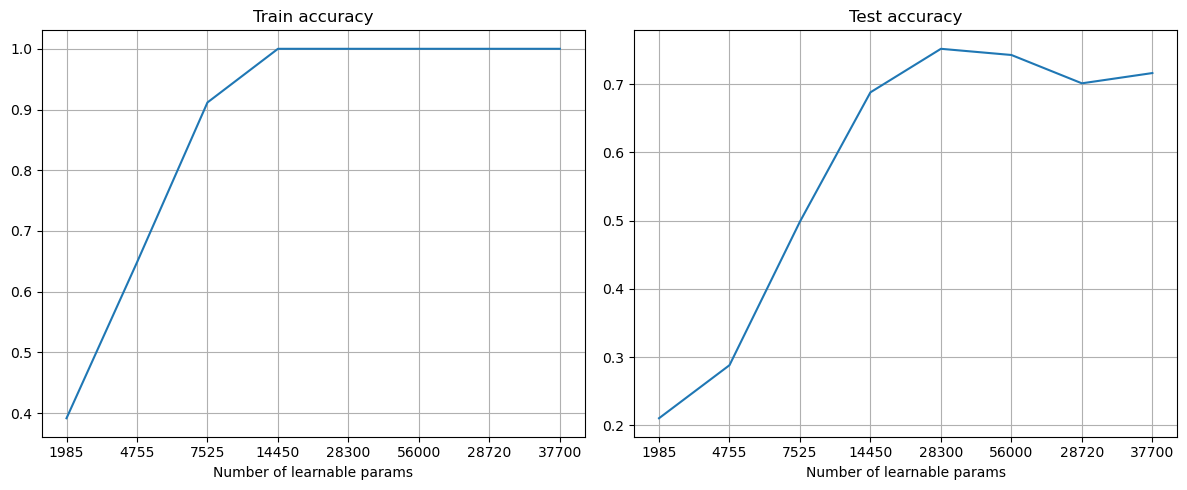

In [12]:
# Import the necessary libraries
# Define the list of hidden layer sizes to try out (feel free to change)
hidden_layer_sizes = [(1,),(3,),(5,),(10,), (20,), (40,), (20,20,),(30,30,20)]
hidden_layer_labels = [param_count(size, X_training, Y_training) for size in hidden_layer_sizes]

# Train the MLPs with the different hidden layer sizes and get the accuracies
start_time = time()  # Start time
train_accuracies, test_accuracies = [], []  # Lists for saving accuracies (train and test)

for size in hidden_layer_sizes:
    print(f"Training MLP of size {size} ...")
    
    MLP=MLPClassifier(hidden_layer_sizes=size,activation = 'relu', max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4,learning_rate_init = 0.1)    #define MLP
    MLP.fit(X_training,Y_training)          #train MLP

    elapsed_time = time() - start_time

    train_accuracies.append(MLP.score(X_training,Y_training))
    test_accuracies.append(MLP.score(X_test,Y_test))

    # Print the time needed for training
    print(f"Time needed for training: {elapsed_time:.2f} seconds")

# Plot the train and test accuracies
plot_accuracies([train_accuracies, test_accuracies], [hidden_layer_labels, hidden_layer_labels], ["Train accuracy", "Test accuracy"])


### Learning rate tuning

Now try also to use different learning rates, while keeping the best *NN* architecture and batch size you have found above. Plot the learning curves (*i.e.*, the variation of the loss over the steps, you can get it from the `loss_curve_` object of sklearn) for the different values of the learning rate. Try to run each training for $600$ iterations. Plot all the curves in the same plot.

Training MLP with learning rate 0.0002 ...
Training MLP with learning rate 0.002 ...
Training MLP with learning rate 0.02 ...
Training MLP with learning rate 0.2 ...
Best learning rate value:  0.02  with score:  0.7391077441077442


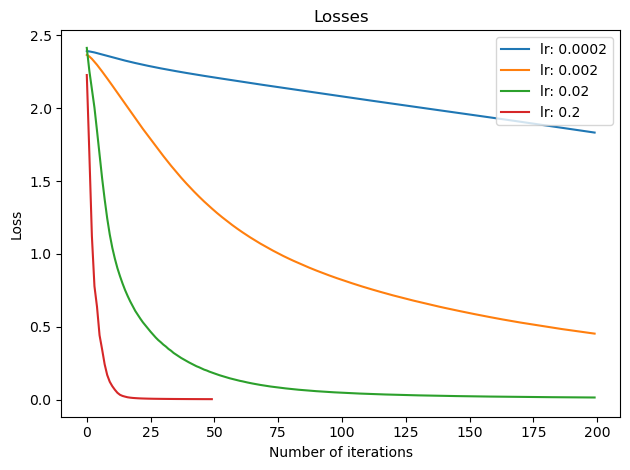

In [13]:
# Define the list of learning rates to try out (feel free to change)
lr_list = [0.0002, 0.002, 0.02, 0.2]

# Train the MLPs with the different lerning rates
scores = {}  # dictionary for saving the scores
losses = {}  # dictionary for saving losses

# Get the best hidden layer sizes and batch size from the previous MLPs
hidden_layers=models.best_params_

for lr in lr_list:
    print(f"Training MLP with learning rate {lr} ...")
    
    MLP=MLPClassifier(hidden_layer_sizes=hidden_layers['hidden_layer_sizes'],activation = 'relu', max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4,learning_rate_init = lr)    #define MLP
    MLP.fit(X_training,Y_training)          #train MLP

    scores[lr]=(MLP.score(X_test,Y_test))
    losses[lr]=MLP.loss_curve_



# Print the best learning rate value and the corresponding score
key_best = max(scores, key = scores.get)
print("Best learning rate value: ", key_best, " with score: ", scores[key_best])

# Plot the losses
plot_loss(losses)

if learning rate is too high we can meet stability problems

### Test the best model

Now get training and test error for a NN with best parameters (architecture and learning rate) from above. Plot the learning curve also for this case.

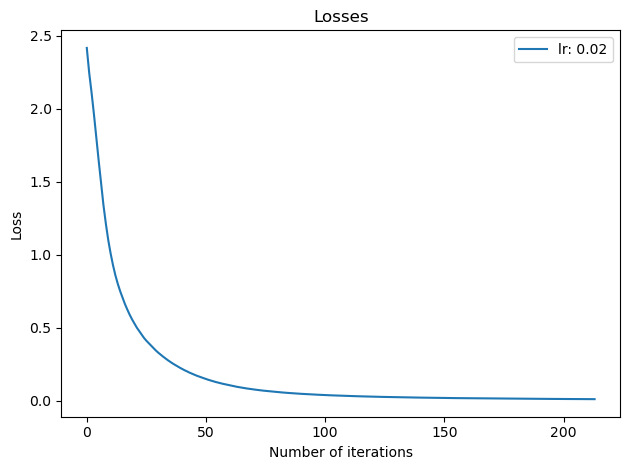

In [14]:
# Define the parameters for the best NN model from CV
best_hidden_layers = hidden_layers['hidden_layer_sizes']
best_learning_rate = 0.02

# TODO: Train the best NN model with the best parameters and compute the training and test error

MLP=MLPClassifier(hidden_layer_sizes=best_hidden_layers,activation = 'relu', max_iter = 600, alpha = 1e-4, solver = 'sgd',tol = 1e-4,learning_rate_init = best_learning_rate)    #define MLP
MLP.fit(X_training,Y_training)          #train MLP

trainerror=MLP.score(X_training,Y_training)
testerror=MLP.score(X_test, Y_test)

# Plot the loss curve for the best NN model
plot_loss({best_learning_rate: MLP.loss_curve_})

---

## B) Classification with Neural Networks (with custom implementation)

In the second part of this notebook we are going to implement a simple *MLP* from scratch. We are going to use the same dataset as before.

### ACTIVATION CLASS
    
Define the Activation class that implements the activation functions and the correspondent derivative. In particular, implement the following activation functions: **ReLu**, **Sigmoid**.

In [15]:
class Activation:
    """
    Activation function class
    """

    def __init__(self, name: str) -> None:
        """
        Constructor for the Activation class.
        Given a string name, it sets the activation function (and derivative) to be used.
        Args:
            name (str): the name of the activation function to be used.
        """

        self.name = name

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function.
        \nReturns:
            np.ndarray: the output of the activation function and the input x (used for backpropagation).
        """

        if self.name == 'relu':
            # Implement the ReLU activation function 
            return np.maximum(0, x), x
        elif self.name == 'sigmoid':
            # Implement the Sigmoid activation function 
            return 1/(1+np.exp(-x)), x
        else:
            raise ValueError('Activation function not supported')

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding derivative of the activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function.
        \nReturns:
            np.ndarray: the derivative of the activation function.
        """

        if self.name == 'relu':
            # Implement the derivative of the ReLU activation function 
            return (np.sign(x)+1)/2
        elif self.name == 'sigmoid':
            # Implement the derivative of the Sigmoid activation function 
            return 1/(1+np.exp(-x))*(1-1/(1+np.exp(-x)))
        else:
            raise ValueError('Activation function not supported')

### MLP CLASS

The following block contains the structure of the *MLP* class. You have to complete the `forward` functions. The `forward` function should compute the forward pass of the network.
Note that to be able to perform backpropagation algorithm we have to keep track of all the computation we do in the forward pass. In particular, this is done in the `cache` variable that is stored at each layer. Note that in order to work properly with the already provided `backprop()` method, the cache has to sored in a specific way. In particular we have chosen that the cache is a tuple containing `(a_prev, W, b)` where:
- `a_prev` is the output of the previous layer (np.ndarray)
- `W` is the current weight matrix (np.ndarray)
- `b` is the current bias vector (np.ndarray)

In [16]:
class DiyMlp:
    """
    A Multi-layer Perceptron implementation.
    keep in mind that all the input are considered with the batch_size as the last dimension.
    """

    def __init__(self, layers: list, learning_rate: float):
        """
        Constructor for the DiyMlp class.
        Given a list of layers and a learning rate, it initializes the parameters of the MLP.
        Each layer a part from the last one use as activation function the ReLU, while the last one uses the sigmoid.
        \nArgs:
            layers (list): a list of layers, each element of the list contains the number of neurons of the layer,
            learning_rate (float): the learning rate used during training
        """

        self.n_layers = len(layers)  # number of layers
        params = {}  # dictionary containing the parameters W and b of each layer

        # For each layer, we define the weight matrix W, the bias vector b and the activation function
        for l in range(1, self.n_layers):
            params[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * 0.01  # initialize the weight matrix of the layer to a normal distribution rescaled by 0.01
            params[f"b{l}"] = np.zeros((layers[l], 1))  # initialize the bias vector of the layer to zeros
            params[f"activation{l}"] = Activation("relu" if l < self.n_layers - 1 else "sigmoid")  # define the activation function of the layer

        self.params = params  # save the parameters of the network
        self.lr = learning_rate  # save the learning rate

    @staticmethod
    def one_hot(x: np.ndarray, n_classes: int) -> np.ndarray:
        """
        It converts the input x into a one-hot encoding.
        \nArgs:
            x (np.ndarray): the input vector containing the labels of the samples.
            n_classes (int): the number of classes.
        \nReturns:
            np.ndarray: the one-hot encoding of x.
        """

        return np.eye(n_classes)[x.reshape(-1)]

    def forward(self, x: np.ndarray) -> tp.Tuple[np.ndarray, list]:
        """
        Implement the forward propagation of the network. For each layer a part the last one, it computes the linear transformation and applies the activation function.
        Given an input x, it computes the forward pass of the network.
        \nArgs:
            x (np.ndarray): the input to the network.
        \nReturns:
            np.ndarray: the output of the network.
            list: a list containing the linear and activation caches.
        """

        caches = []  # list for storing the linear and activation caches

        out = None  # output of the layer

        # For each layer of the model a part the last one
        for l in range(1, self.n_layers):
            prev = cp(x) if l == 1 else out  # storing the input of the layer, i.e., the output of the previous layer
            
            # Linear Hypothesis
            # Compute the linear hypothesis z = W*a_prev + b (replace None with your code)
            z = np.dot(self.params[f"W{l}"], prev) + self.params[f"b{l}"]
            
            # Storing the linear cache for backpropagation = (a_prev, W, b)
            # Store the linear cache (replace None with your code)
            linear_cache = (prev, self.params[f"W{l}"], self.params[f"b{l}"])
            
            # Applying the activation function on linear hypothesis
            # Compute the activation function on z (replace None with your code)
            out, activation_cache = self.params[f"activation{l}"](z)
            
            # storing both the linear and activation cache
            caches.append((linear_cache, activation_cache))
        
        return out, caches
    
    @staticmethod
    def cost_function(out: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Given the output of the network out and the ground truth labels y, it computes the cost function (loss).
        This implementation uses the cross-entropy loss.
        \nArgs:
            out (np.ndarray): the output of the network.
            y (np.ndarray): the ground truth labels.
        \nReturns:
            np.ndarray: the cost value.
        """
        
        return (-1/y.shape[1]) * (np.dot(np.log(out), y.T) + np.dot(np.log(1-out), 1-y.T))

    @staticmethod
    def one_layer_backward(d_pred: np.ndarray, cache: tp.List[tp.Tuple[np.ndarray]], derivative_activation: Activation.derivative) -> tuple:
        """
        Given the derivative of the loss with respect to the output of the layer d_pred and the linear and activation cache,
        it computes the derivative of the loss with respect to the input of the layer d_pred_prev, the derivative of the loss
        with respect to the weights d_w and the derivative of the loss with respect to the bias d_b.
        \nArgs:
            d_pred (np.ndarray): the derivative of the loss with respect to the output of the layer.
            cache (list): a list containing the linear and activation cache.
            derivative_activation (Activation.derivative): the derivative of the activation function.   
        \nReturns:
            tuple: a tuple containing the derivative of the loss with respect to the input of the layer dA_prev,
            the derivative of the loss with respect to the weights dW and the derivative of the loss with respect to the bias db.
        """

        linear_cache, activation_cache = cache  # retrieve the linear and activation cache
        
        z = activation_cache
        d_z = d_pred * derivative_activation(z) # compute the derivative of the loss with respect to z
        
        pred_prev, w, _ = linear_cache  # retrieve the input of the layer and the weights from the cache
        m = pred_prev.shape[1]  # retrieve the number of samples
        
        d_w = (1/m) * np.dot(d_z, pred_prev.T)  # compute the derivative of the loss with respect to w
        d_b = (1/m) * np.sum(d_z, axis=1, keepdims=True)  # compute the derivative of the loss with respect to b
        d_pred_prev = np.dot(w.T, d_z)  # compute the derivative of the loss with respect to the input of the layer
        
        return d_pred_prev, d_w, d_b
    
    def backprop(self, pred, labels, caches) -> dict:
        """
        Given the output of the network pred, the ground truth labels y and the caches,
        it computes the backward pass of the network.
        \nArgs:
            pred (np.ndarray): the output of the network.
            labels (np.ndarray): the ground truth labels.
            caches (list): a list containing the linear and activation caches.
        \nReturns:
            dict: a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        grads = {}  # dictionary for storing the gradients
        labels = labels.reshape(pred.shape) # reshape the labels to have the same shape as the output of the network
        caches_len = len(caches)
        
        # Compute the grad of the last layer
        d_pred = -(np.divide(labels, pred) - np.divide(1-labels, 1-pred))  # compute the derivative of the loss with respect to the output of the network
        current_cache = caches[caches_len - 1]  # retrieve the linear and activation cache of the last layer
        grads[f"d_pred{caches_len - 1}"], grads[f"dW{caches_len}"], grads[f"db{caches_len}"] = self.one_layer_backward(d_pred, current_cache, self.params[f"activation{caches_len}"].derivative)
        
        # Compute the grad for all the other layers in reverse order
        for l in reversed(range(caches_len - 1)):
            current_cache = caches[l]  # retrieve the linear and activation cache of the layer
            grads[f"d_pred{l}"], grads[f"dW{l + 1}"], grads[f"db{l + 1}"] = self.one_layer_backward(grads[f"d_pred{l + 1}"], current_cache, self.params[f"activation{l + 1}"].derivative)  # compute the derivative of the loss with respect to the output of the next layer
            
        return grads
    
    def update_parameters(self, grads: dict) -> None:
        """
        Given the gradients grads,it updates the weight matrix and the bias vector using the stochastic gradient descent.
        \nArgs:
            grads (dict): a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        for l in range(self.n_layers - 1):
            self.params[f"W{l + 1}"] = self.params[f"W{l + 1}"] - self.lr*grads[f"dW{l + 1}"]
            self.params[f"b{l + 1}"] = self.params[f"b{l + 1}"] - self.lr*grads[f"db{l + 1}"]

    def train(self, x: np.ndarray, y: np.ndarray, epochs: int) -> None:
        """
        Given the input x, the ground truth labels y and the number of epochs, it trains the network.
        \nArgs:
            x (np.ndarray): the input to the network.
            y (np.ndarray): the ground truth labels.
            epochs (int): the number of epochs.
        """

        x = x.T  # transpose the input to have the batch size as the first dimension
        y = self.one_hot(y, np.unique(y).shape[0]).T  # one-hot encode the labels and transpose to have the batch size as the first dimension

        cost_history = []  # list for storing the cost at each epoch
        
        # For each epoch ...
        for _ in range(epochs):
            out, caches = self.forward(x)  # compute the output of the network and retrieve the caches
            cost = self.cost_function(out, y)  # compute the cost
            cost_history.append(cost)  # save the cost
            grads = self.backprop(out, y, caches)  # compute the gradients
            
            self.update_parameters(grads)  # update the parameters of the network using the gradients

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Given the input x, it computes the output of the network.
        \nArgs:
            x (np.ndarray): the input to the network.
        \nReturns:
            np.ndarray: the output of the network.
        """

        x = x.T  # transpose the input to have the batch size as the first dimension
        out, _ = self.forward(x)  # compute the output of the network
        predictions = np.argmax(out, axis=0)  # get the predictions
        
        return predictions

### TRAINING

Train the *MLP* you have implemented. Then print its accuracy and plot the confusion matrix to better visualize the performance of the model.

In [17]:
# Define the MLP object
learning_rate = 0.2
diy_mlp = DiyMlp([784, 40, 10], learning_rate)

# Train the MLP and compute the accuracy on the test set

diy_mlp.train(X_training, Y_training, 200)


Y_pred = diy_mlp.predict(X_test) # predicted labels on test set

accuracy = 1 - np.sum(Y_pred != Y_test) / len(Y_test)
print("Accuracy on the test set: ", accuracy)

Accuracy on the test set:  0.7523063973063973


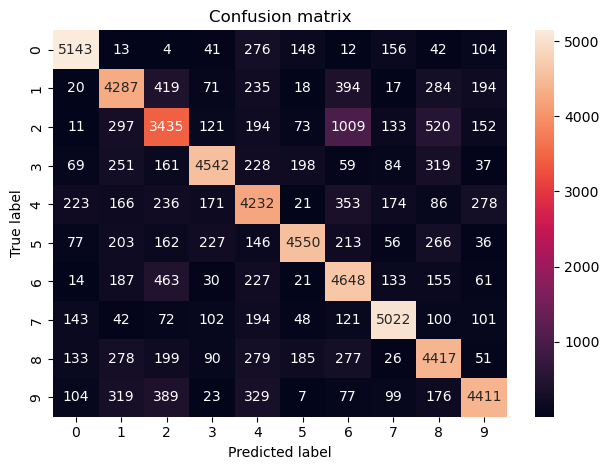

In [18]:
# Compute the confusion matrix
cm=confusion_matrix(Y_test,Y_pred)

# Plot the confusion matrix
plot_conf_matrix(cm)